In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as kb
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

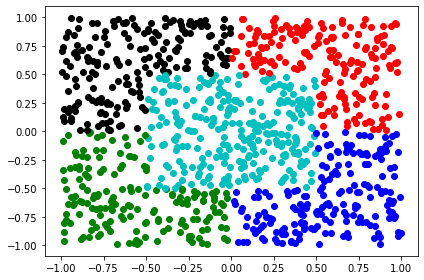

(850, 2, 2)
(850,)


In [4]:
def DataGenerator(center, length, numberOfdata):
    
    fig = plt.figure()
    
    # inputs
    tmp = tf.random.uniform([numberOfdata, 2], maxval = length)
    a = tf.constant([[center[0] - length/2.0, center[1] - length/2.0]])
    b = tf.constant([numberOfdata,1])
    bias = tf.tile(a, b)
    inputs_ = tf.add(tmp, bias)
    # outputs
    outputs_ = np.zeros([numberOfdata])
    
    for idx, elem in enumerate(inputs_):
        if abs(elem[0] - center[0]) < length/4.0 and abs(elem[1] - center[1]) < length/4.0:
            plt.scatter(elem[0], elem[1], c='c')
            outputs_[idx] = 4
        elif elem[0] > center[0] and elem[1] > center[1]:
            plt.scatter(elem[0], elem[1], c='r')
            outputs_[idx] = 0
        elif elem[0] > center[0]:
            plt.scatter(elem[0], elem[1], c='b')
            outputs_[idx] = 1
        elif elem[0] <= center[0] and elem[1] <= center[1]:
            plt.scatter(elem[0], elem[1], c='g')
            outputs_[idx] = 2
        elif elem[0] <= center[0]:
            plt.scatter(elem[0], elem[1], c='k')
            outputs_[idx] = 3
    fig.tight_layout()
    plt.savefig('trainDataset.png')
    plt.show()
    
    return inputs_, outputs_
    
    
    #tmp = tf.fill([numberOfdata, 2], [1,2])
    #print(tmp)

    
centerPoint = [0, 0]
length = 2
numOfPoint_total = 1000

inputs_, outputs_ = DataGenerator(centerPoint, length, numOfPoint_total)

# take data for its key
buffer = {}

for idx, output__ in enumerate(outputs_):
    if output__ in buffer.keys():
        buffer[output__].append(inputs_[idx])
    else:
        buffer[output__] = [inputs_[idx]]

numOfPoint_min = np.Inf
for i, v in buffer.items():
    if np.less(len(v), numOfPoint_min):
        numOfPoint_min = len(v)
    buffer[i] = np.array(v)
#print(numOfPoint_min)
    
# classify same or dif
inputs = np.empty([1, 2, 2])
outputs = np.empty([1])
ratio_same = 0.6
for key, value in buffer.items():
    for key_, value_ in buffer.items():
        # take same cases
        if key == key_:
            choice1 = np.random.choice(value.shape[0], int(numOfPoint_min * ratio_same), replace=False)
            choosen1 = np.expand_dims(value[choice1], axis=1)
            choice2 = np.random.choice(value_.shape[0], int(numOfPoint_min * ratio_same), replace=False)
            choosen2 = np.expand_dims(value_[choice2], axis=1)   
            
            tmp_same = np.concatenate((choosen1, choosen2), axis=1)
            inputs = np.concatenate((inputs, tmp_same), axis=0)
            
            #tmp_same = np.concatenate((choosen2, choosen1), axis=1)
            #inputs = np.concatenate((inputs, tmp_same), axis=0)
            
            #outputs = np.concatenate(   (outputs,   np.full(    (2*int(numOfPoint_min * ratio_same)), 1     )  ), axis=0          )
            outputs = np.concatenate(   (outputs,   np.full(    (int(numOfPoint_min * ratio_same)), 1     )  ), axis=0          )
            
        
        # take different cases
        
        else:
            choice1 = np.random.choice(value.shape[0], int(numOfPoint_min * (1 - ratio_same) / (len(buffer.keys()) - 1)), replace=False)
            choosen1 = np.expand_dims(value[choice1], axis=1)
            choice2 = np.random.choice(value_.shape[0], int(numOfPoint_min * (1 - ratio_same) / (len(buffer.keys()) - 1)), replace=False)
            choosen2 = np.expand_dims(value_[choice2], axis=1)   
            
            tmp_dif = np.concatenate((choosen1, choosen2), axis=1)
            inputs = np.concatenate((inputs, tmp_dif), axis=0)
            
            #tmp_dif = np.concatenate((choosen2, choosen1), axis=1)
            #inputs = np.concatenate((inputs, tmp_dif), axis=0)
            
            #outputs = np.concatenate(   (outputs,   np.full(    (2*int(numOfPoint_min * (1 - ratio_same) / (len(buffer.keys()) - 1))), 0     )  ), axis=0          )
            outputs = np.concatenate(   (outputs,   np.full(    (int(numOfPoint_min * (1 - ratio_same) / (len(buffer.keys()) - 1))), 0     )  ), axis=0          )
        

#print(inputs.shape)
#print(outputs.shape)


inputs = np.delete(inputs, 0, axis=0)
outputs = np.delete(outputs, 0, axis=0)

print(inputs.shape)
print(outputs.shape)


dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs)).shuffle(inputs.shape[0], reshuffle_each_iteration=True)

dataset_batched = dataset.batch(32, drop_remainder=True)
numberOfData = dataset_batched.cardinality().numpy()
trainDataset = dataset_batched.take(int(numberOfData * 0.7))
validDataset = dataset_batched.skip(int(numberOfData * 0.7))

In [306]:
class MyModel(Model):
    def __init__(self, list_units):
        super(MyModel, self).__init__()
        
        self.layers_custom = self.create_layers(list_units)
        self.lastLayer = Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.001))
        
    def create_layers(self, list_units):
        layers = []
        for units in list_units:
            layers.append(Dense(units, activation='swish', kernel_regularizer=keras.regularizers.l2(0.001)))
        return layers

    def call(self, x):
        
        x_1 = x[:,0,:]
        x_2 = x[:,1,:]
        #print(x_1.shape)
        x = tf.concat([x_1, x_2], 1)
        
        for layer in self.layers_custom:
            x = layer(x)
        x = self.lastLayer(x)
        
        return x

    



@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        #predictions = model(images)
        
        
        ######################################
        predictions1 = model(images)
        tmp1 = tf.expand_dims(images[:,0,:], axis=1)
        tmp2 = tf.expand_dims(images[:,1,:], axis=1)
        switched = tf.concat([tmp2, tmp1], 1)
        predictions2 = model(switched)
        
        predictions = tf.concat([predictions1, predictions2], 0)
        labels = tf.concat([labels, labels], 0)
        #print(predictions.shape)
        ######################################
        
        loss = loss_object(labels, predictions)
        train_loss(loss)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_acc.update_state(labels, predictions)
    

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    valid_loss(t_loss)
    valid_acc.update_state(labels, predictions)

에포크: 20557, 손실: 0.1312, 정확도: 94.913, 테스트 손실: 0.1245, 테스트 정확도: 95.240
Early Stopped !


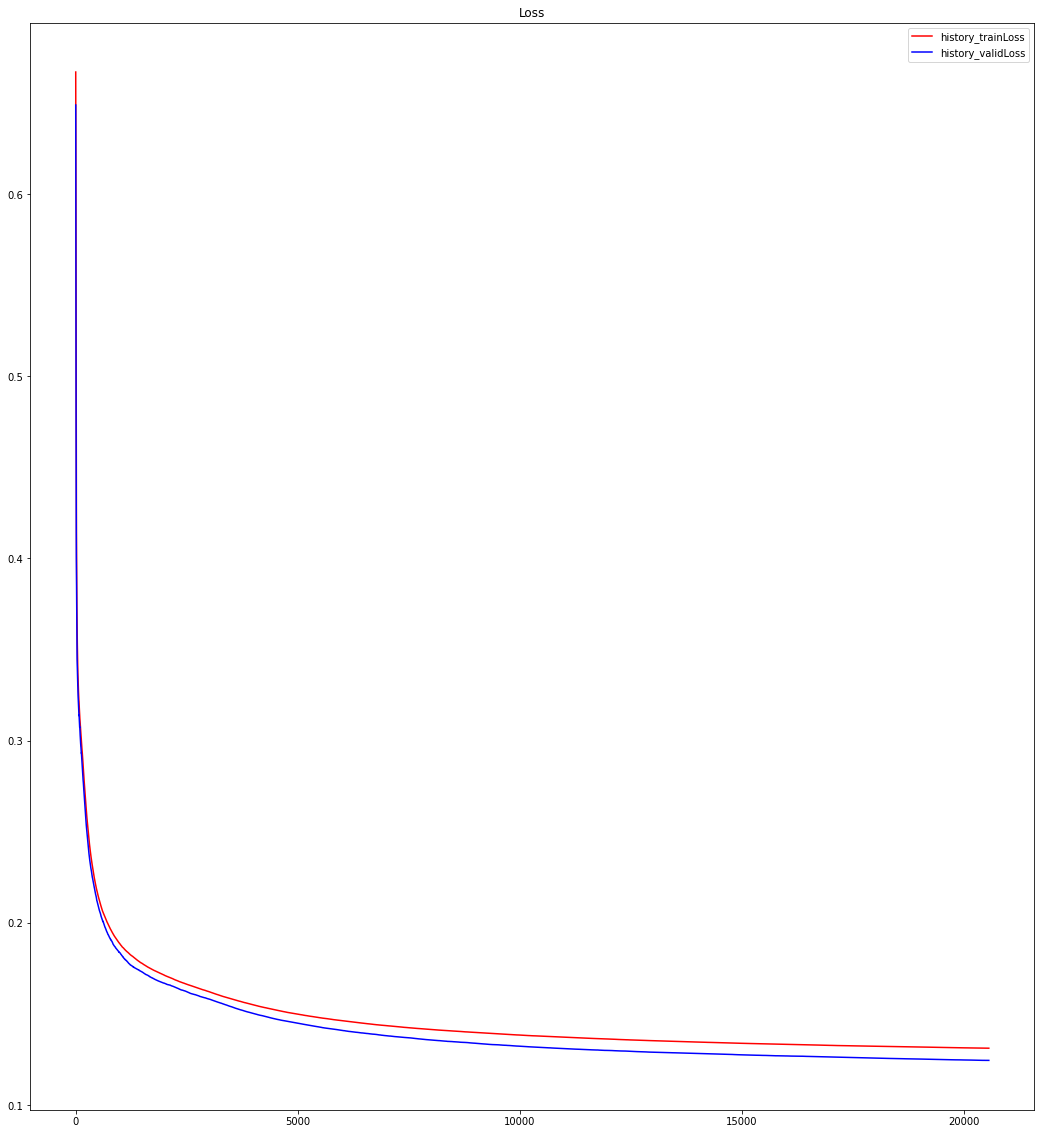

In [307]:
model = MyModel([7, 7])

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.BinaryAccuracy()

valid_loss = tf.keras.metrics.Mean()
valid_acc = tf.keras.metrics.BinaryAccuracy()

EPOCHS = 50000
patience = 50
stopped_epoch = 0
best_weights = None
best = np.Inf
wait = 0


history_trainLoss = []
history_validLoss = []

for epoch in range(EPOCHS):
    clear_output(wait=True)
    
    for images, labels in trainDataset:
        train_step(images, tf.expand_dims(labels, axis=-1))
    for images, labels in validDataset:
        test_step(images, tf.expand_dims(labels, axis=-1))
        
    template = '에포크: {}, 손실: {:.4f}, 정확도: {:.3f}, 테스트 손실: {:.4f}, 테스트 정확도: {:.3f}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_acc.result()*100,
                         valid_loss.result(),
                         valid_acc.result()*100))
    
    history_trainLoss.append(train_loss.result())
    history_validLoss.append(valid_loss.result())
    
    if np.less(float(valid_loss.result()), best):
        best = float(valid_loss.result())
        best_weights = model.get_weights()
        wait = 0
    else:
        wait +=1
        if wait >= patience:
            model.set_weights(best_weights)
            learning_rate /= 10.0
            #optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
            
            #if learning_rate <= 0.00001:
            stopped_epoch = epoch
            print('Early Stopped !')
            break
            
        

fig= plt.figure(figsize=(18,20))
plt.title('Loss')
x = np.arange(len(history_trainLoss))
plt.plot(x, history_trainLoss, 'r-', label = 'history_trainLoss')
plt.plot(x, history_validLoss, 'b-', label = 'history_validLoss')
plt.legend()

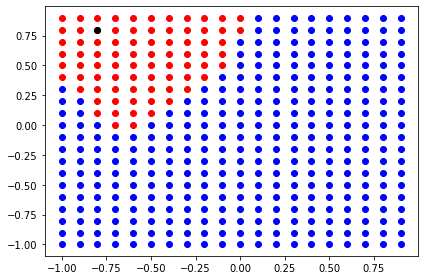

In [302]:
fig = plt.figure()

Point_pivot_ = [-0.8, 0.8]

numOfPoint_test = 20
inputs_test = np.empty([1, 2, 2])
Point_pivot = np.expand_dims(np.array([Point_pivot_]), axis=1)
#print(Point_pivot.shape)
for x in range(numOfPoint_test):
    for y in range(numOfPoint_test):
        x_ = centerPoint[0] - length / 2.0 + x * float(length / numOfPoint_test)
        y_ = centerPoint[1] - length / 2.0 + y * float(length / numOfPoint_test)
        
        tmp1 = np.expand_dims(np.array([[x_, y_]]), axis=1)
        
        tmp2 = np.concatenate((tmp1, Point_pivot), axis=1)
        
        inputs_test = np.concatenate((inputs_test, tmp2), axis=0)
        
inputs_test = np.delete(inputs_test, 0, axis=0)
#print(inputs_test.shape)

predictions = np.squeeze(model(inputs_test))
#print(predictions.shape)
for i, v in enumerate(predictions):
    elem = inputs_test[i, 0, :]
    if v > 0.8:
        plt.scatter(elem[0], elem[1], c='r')
    else:
        plt.scatter(elem[0], elem[1], c='b')

plt.scatter(Point_pivot_[0], Point_pivot_[1], c='k')
fig.tight_layout()
#plt.savefig('trainDataset.png')
plt.show()

    